In [1]:
import numpy as np
import pandas as pd
import zipfile
import datetime
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
b18 = pd.read_csv('bay2018_clean.csv')

In [3]:
base_color = sb.color_palette()[0]
plt.style.use('ggplot')
sb.set_palette("muted")

# What is purpose that people take bikeshare?
## Let's analyze Bay area 2018 bikeshare data, here is around 1.8 million bikeshare trip data.
## First, we are going to take a look the uers's feature.

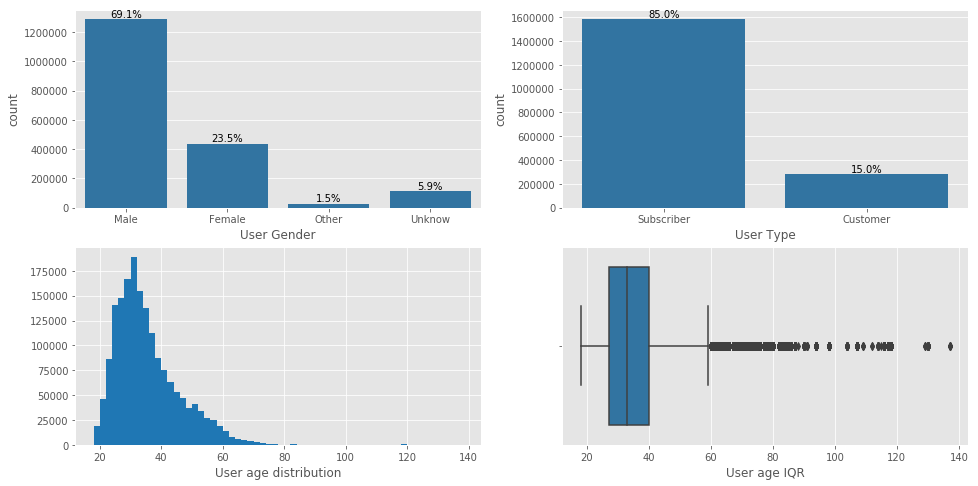

In [4]:
plt.figure(figsize=[16,8]);

plt.subplot(2,2,1);
ax1 = sb.countplot(data=b18,x='member_gender',color=base_color, order = ['Male','Female','Other','Unknow']);
for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{:.1f}%'.format(100.*y/b18.shape[0]), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
plt.xlabel('User Gender');
    
plt.subplot(2,2,2);
ax2 = sb.countplot(data=b18,x='user_type',color=base_color);
for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{:.1f}%'.format(100.*y/b18.shape[0]), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
plt.xlabel('User Type');

plt.subplot(2,2,3);
plt.hist(data=b18, x='age_of_member',bins = np.arange(18,138+2,2),color=base_color);
plt.xlabel('User age distribution');

plt.subplot(2,2,4);
sb.boxplot(data = b18, x = 'age_of_member',color=base_color);
plt.xlabel('User age IQR');

### Male user is 69.1%, Female user is 23.5%, 1.5% user choose gender is 'Other', and 5.9% user didn't provide gender information.
### 85% user is subscriber(membership), and 15% user is casual customer.
### 50% user's age between 27-40 years old, median age is 33 years old.

In [5]:
b18.age_of_member.describe()

count    1.753003e+06
mean     3.491204e+01
std      1.044289e+01
min      1.800000e+01
25%      2.700000e+01
50%      3.300000e+01
75%      4.000000e+01
max      1.370000e+02
Name: age_of_member, dtype: float64

### Next, let's take a look trip feature, how many minutes people will take bikeshare for their purpose? How many trip is one way and round trip?

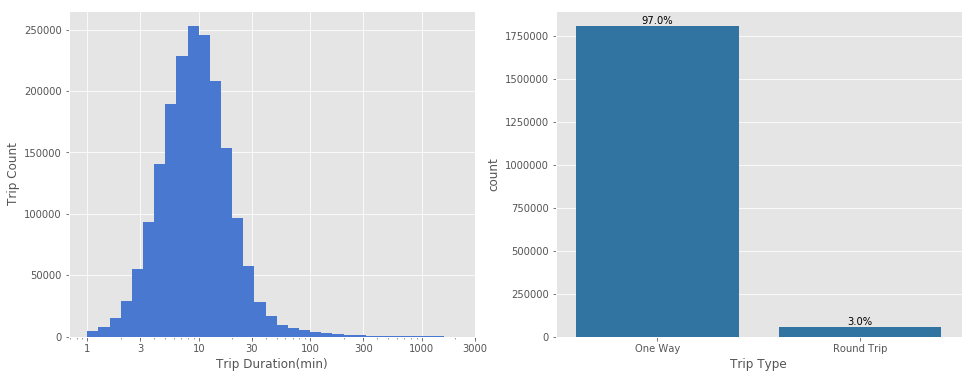

In [6]:
plt.figure(figsize=[16,6])
plt.subplot(1,2,1)
bin_duration = 10**np.arange(0, 3.3+0.1, 0.1)
ticks = [1,3,10,30,100,300,1000,3000]
labels = ['{}'.format(v) for v in ticks]
plt.hist(b18.duration, bins = bin_duration);
plt.xscale('log');
plt.xticks(ticks, labels);
plt.xlabel('Trip Duration(min)');
plt.ylabel('Trip Count');

plt.subplot(1,2,2)
ax3 = sb.countplot(data=b18,x='trip_route_category',color=base_color);
for p in ax3.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax3.annotate('{:.1f}%'.format(100.*y/b18.shape[0]), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
plt.xlabel('Trip Type');

### 50% Trip duration is between 5.8 - 14.5 minutes, median duration is 9.3 minutes.
### 97% Trip is One way trip, 3% is round trip.

In [7]:
b18.duration.describe()

count    1.863721e+06
mean     1.428838e+01
std      3.950631e+01
min      1.016667e+00
25%      5.833333e+00
50%      9.266667e+00
75%      1.453333e+01
max      1.439433e+03
Name: duration, dtype: float64

### Now let's count the trip by start time, in one day 24 hours, what time is the people take bikeshare most frequent?

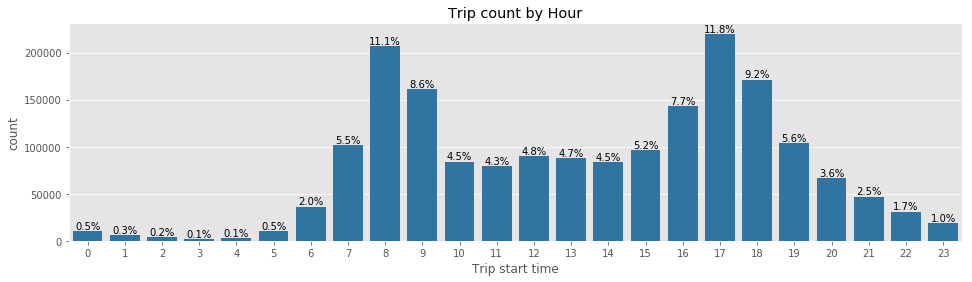

In [8]:
plt.figure(figsize=[16,4])
ax4 = sb.countplot(data=b18,x='hour_start',color=base_color);
for p in ax4.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax4.annotate('{:.1f}%'.format(100.*y/b18.shape[0]), (x.mean(), y), 
            ha='center', va='bottom')
plt.xlabel('Trip start time');
plt.title('Trip count by Hour');

### OK, Here is very obvious distribution of hour. Most trip occur in commuting time.
### Let me take a deep exploration, add a feature 'Day'

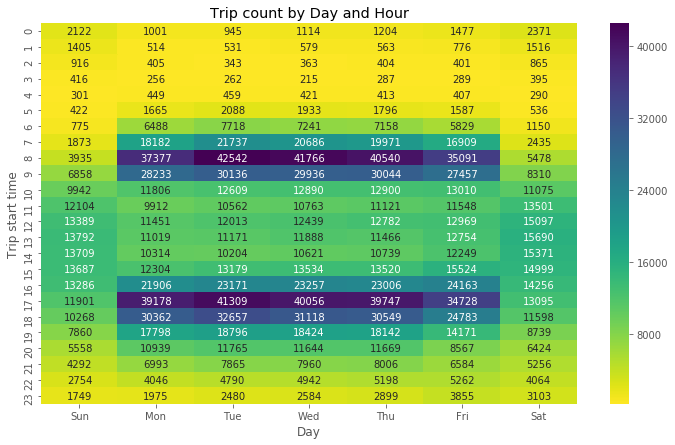

In [9]:
plt.figure(figsize=[12,7]);
week_hour_counts = b18.groupby(['weekday','hour_start']).size()
week_hour_counts = week_hour_counts.reset_index(name = 'counts')
week_hour_counts = week_hour_counts.pivot(index = 'hour_start', columns = 'weekday', values = 'counts')

ax = sb.heatmap(week_hour_counts, annot = True, fmt = 'd', cmap = 'viridis_r');
day_ticks = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
ax.set_xticklabels(day_ticks);
plt.xlabel('Day');
plt.ylabel('Trip start time');
plt.title('Trip count by Day and Hour');

### There we go! From Monday to Friday, commuting time is most busy time.
### But we also saw that time on weekend, from 10:00 - 16:00 is more busy than same time on weekday.
### So, let me change the measurement value to mean of duration.

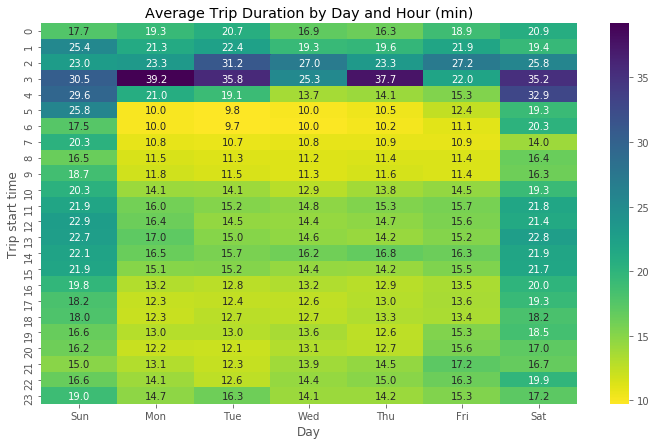

In [10]:
plt.figure(figsize=[12,7]);

hour_week_mean = b18.groupby(['hour_start','weekday']).mean()['duration']
hour_week_mean = hour_week_mean.reset_index(name = 'duration')
hour_week_mean = hour_week_mean.pivot(index = 'hour_start', columns = 'weekday', values = 'duration')

ax = sb.heatmap(hour_week_mean, annot = True, fmt = '.1f', cmap = 'viridis_r');
day_ticks = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
ax.set_xticklabels(day_ticks);
plt.xlabel('Day');
plt.ylabel('Trip start time');
plt.title('Average Trip Duration by Day and Hour (min)');

### Now we saw that at Non-commuting time, people will take longer time to use bikeshare. And the lowerst average trip duration is at commuting time. Sure, the reason why people use bike go to work is saving time!
### Next, I want to know how does user feature influence trip duration.
### Let me caculate average trip duration by gender and trip type, user type.

C:\Users\james\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


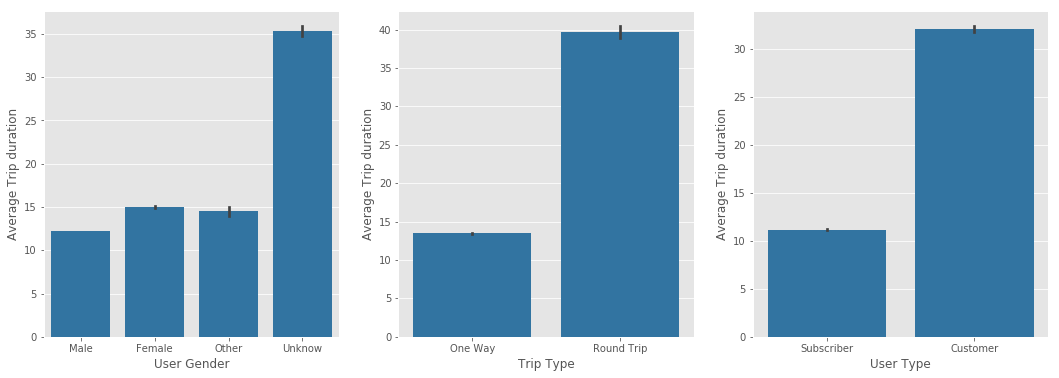

In [11]:
plt.figure(figsize=[18,6]);

plt.subplot(1,3,1)
sb.barplot(data = b18, x =  'member_gender', y = 'duration',color=base_color,order = ['Male','Female','Other','Unknow']);
plt.xlabel('User Gender')
plt.ylabel('Average Trip duration')

plt.subplot(1,3,2)
sb.barplot(data = b18, x = 'trip_route_category', y = 'duration',color=base_color);
plt.xlabel('Trip Type')
plt.ylabel('Average Trip duration')

plt.subplot(1,3,3)
sb.barplot(data = b18, x = 'user_type', y = 'duration',color=base_color);
plt.xlabel('User Type')
plt.ylabel('Average Trip duration');

### Put them together, use heatmap to look how much is it diffrent.

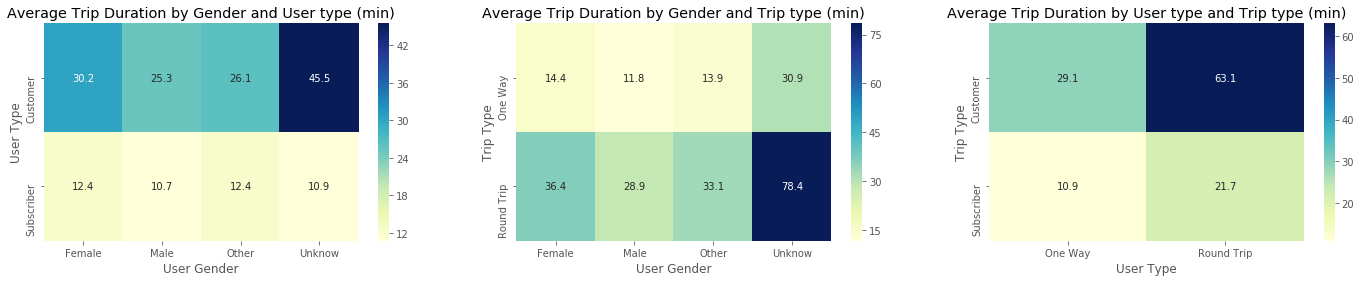

In [12]:

gender_oneway_duration = b18.groupby(['member_gender','trip_route_category']).mean()['duration']
gender_oneway_duration = gender_oneway_duration.reset_index(name = 'duration')
gender_oneway_duration = gender_oneway_duration.pivot(columns = 'member_gender', index = 'trip_route_category', values = 'duration')

gender_user_duration = b18.groupby(['member_gender','user_type']).mean()['duration']
gender_user_duration = gender_user_duration.reset_index(name = 'duration')
gender_user_duration = gender_user_duration.pivot(columns = 'member_gender', index = 'user_type', values = 'duration')

user_oneway_duration = b18.groupby(['user_type','trip_route_category']).mean()['duration']
user_oneway_duration = user_oneway_duration.reset_index(name = 'duration')
user_oneway_duration = user_oneway_duration.pivot(index = 'user_type', columns = 'trip_route_category', values = 'duration')


plt.figure(figsize = [24,4])

plt.subplot(1,3,1)
sb.heatmap(gender_user_duration, annot = True, fmt = '.1f', cmap = 'YlGnBu');
plt.ylabel('User Type');
plt.xlabel('User Gender');
plt.title('Average Trip Duration by Gender and User type (min)');

plt.subplot(1,3,2)
sb.heatmap(gender_oneway_duration, annot = True, fmt = '.1f', cmap = 'YlGnBu')
plt.ylabel('Trip Type');
plt.xlabel('User Gender');
plt.title('Average Trip Duration by Gender and Trip type (min)');

plt.subplot(1,3,3)
sb.heatmap(user_oneway_duration, annot = True, fmt = '.1f', cmap = 'YlGnBu')
plt.ylabel('Trip Type');
plt.xlabel('User Type');
plt.title('Average Trip Duration by User type and Trip type (min)');

### The features of higher average trip duration are 'Unknow' gender, Round Trip, Casual user
### The features of lower average trip duration are 'Male','Female','Other' gender & One Way, Subscriber user

### Let's go back to look at the trip count with 'Gender', 'User type', 'Trip type, and add time feature 'Day'.
### I will not share the y axis unit, because I want to see trend.

C:\Users\james\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\james\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


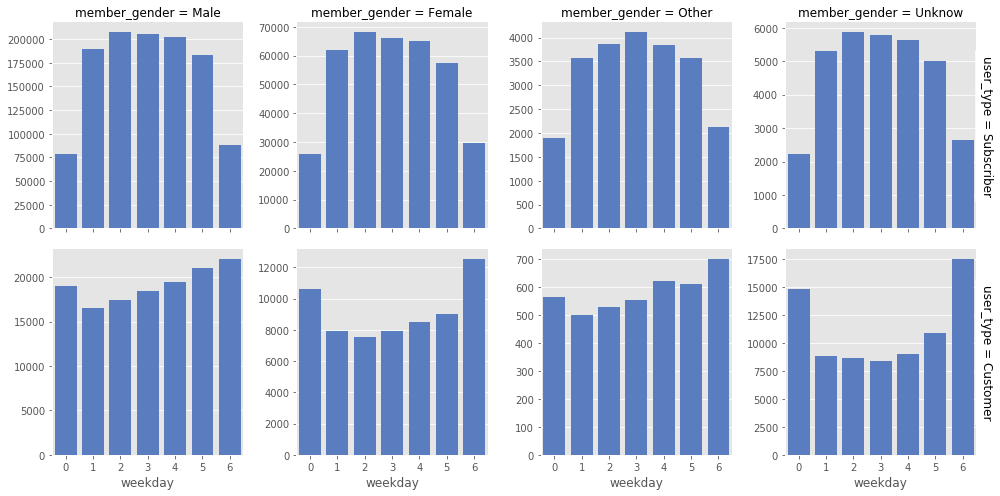

In [13]:
g = sb.FacetGrid(data = b18, col = 'member_gender', row = 'user_type', size = 3.5,
                margin_titles = True, sharey = False, col_order = ['Male','Female','Other','Unknow'])
g.map(sb.countplot, 'weekday');

C:\Users\james\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\james\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


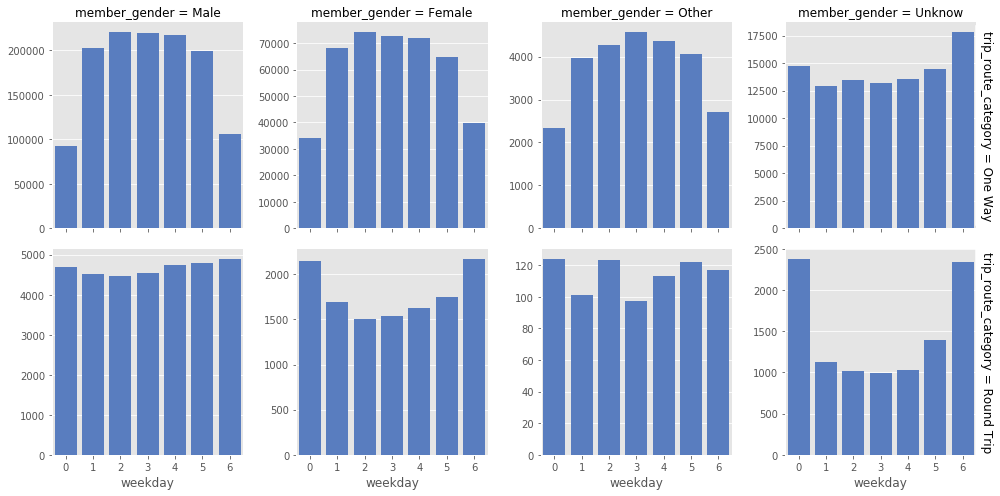

In [14]:
g = sb.FacetGrid(data = b18, col = 'member_gender', row = 'trip_route_category', size = 3.5,
                margin_titles = True, sharey=False,col_order = ['Male','Female','Other','Unknow'])
g.map(sb.countplot, 'weekday');

## From the distribution by day, we knew that Subscriber user usualy use bike for going to work and home on weekday commuting time, by One Way trip.
## The casual user usualy use bike for travel on weekend, by Round trip. And he or she will not provide personal information probably.